# Laboratory practice № 7 (Controlability and observability)

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 8

## Preparation

In [21]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
from matplotlib.ticker import FormatStrFormatter
import scipy

In [2]:
dt = 0.001

In [3]:
t = sympy.symbols("t",real=True)

In [5]:
def grammian_cont(a, b, t_1):
    return sympy.integrate(sympy.exp(a*t) @ b @ b.T @ sympy.exp(a.T*t),(t,0,t_1))

In [24]:
def grammian_obs_sym(a, c, t_1):
    return sympy.integrate(sympy.exp(a.T*t) @ c.T @ c @ sympy.exp(a*t),(t,0,t_1))

def grammian_obs_sci(a, c, t_1):
    func = lambda x : scipy.linalg.expm(a.T*x) @ c.T @ c @ scipy.linalg.expm(a*x)
    return scipy.integrate.quad_vec(func,0,t_1)

## Task 1

In [6]:
A = np.array([
    [7, -7, 8],
    [6, -5, 6],
    [-6, 4, -7]
])

B = np.array([
    [-4],
    [-2],
    [4]
])

x_1 = np.array([
    [5],
    [3],
    [-3]
])

### subtask 1

In [7]:
U = np.concatenate([B, A.dot(B), A.dot(A.dot(B))],axis=1)
U

array([[ -4,  18, -40],
       [ -2,  10, -14],
       [  4, -12,  16]])

In [8]:
np.linalg.matrix_rank(U)

3

Rank of controllability matrix is n, so the system is fully controllable

### subtask 2

In [9]:
A_sym = sympy.Matrix(A)
B_sym = sympy.Matrix(B)
P, J = A_sym.jordan_form()
J

In [12]:
P

Matrix([
[-1, -3/2 + I/2, -3/2 - I/2],
[ 0,         -1,         -1],
[ 1,          1,          1]])

Method 1 (rank criterion):

In [13]:
np.linalg.matrix_rank(np.concatenate([A-(-1)*np.identity(3),B],axis=1))

3

In [14]:
np.linalg.matrix_rank(np.concatenate([A-(-2 - 3j)*np.identity(3),B],axis=1))

3

In [15]:
np.linalg.matrix_rank(np.concatenate([A-(-2 + 3j)*np.identity(3),B],axis=1))

3

Method 2 (Jordan representation)

In [16]:
J

Matrix([
[-1,        0,        0],
[ 0, -2 - 3*I,        0],
[ 0,        0, -2 + 3*I]])

In [17]:
P.inv() @ B_sym

Matrix([
[    2],
[1 - I],
[1 + I]])

### subtask 3
A, B - fully controllable, so x_1 is in controllable space

### subtask 4

In [18]:
G_cont = grammian_cont(A_sym,B_sym,3)
G_cont.simplify()
G_cont

Matrix([
[  -2*exp(-6) + 4*exp(-9)*cos(9)/3 - 29*exp(-12)*cos(9)**2/26 - 101*exp(-12)*sin(9)**2/26 - 2*exp(-12)*sin(9)*cos(9)/13 + 4*exp(-9)*sin(9) + 139/78, -17*exp(-12)*cos(9)**2/26 - 61*exp(-12)*sin(9)**2/26 + 6*exp(-12)*sin(9)*cos(9)/13 + 4*exp(-9)*sin(9)/3 + 17/26, -155/78 - 10*exp(-9)*sin(9)/3 - 6*exp(-12)*sin(9)*cos(9)/13 + 61*exp(-12)*sin(9)**2/26 + 17*exp(-12)*cos(9)**2/26 - 2*exp(-9)*cos(9)/3 + 2*exp(-6)],
[                                   -17*exp(-12)*cos(9)**2/26 - 61*exp(-12)*sin(9)**2/26 + 6*exp(-12)*sin(9)*cos(9)/13 + 4*exp(-9)*sin(9)/3 + 17/26,                        -7*exp(-12)*cos(9)**2/13 - 19*exp(-12)*sin(9)**2/13 + 8*exp(-12)*sin(9)*cos(9)/13 + 7/13,                                      -7/13 - 4*exp(-9)*sin(9)/3 - 8*exp(-12)*sin(9)*cos(9)/13 + 19*exp(-12)*sin(9)**2/13 + 7*exp(-12)*cos(9)**2/13],
[-155/78 - 10*exp(-9)*sin(9)/3 - 6*exp(-12)*sin(9)*cos(9)/13 + 61*exp(-12)*sin(9)**2/26 + 17*exp(-12)*cos(9)**2/26 - 2*exp(-9)*cos(9)/3 + 2*exp(-6),   -7/13 - 4*exp(-9)*

In [19]:
G_cont.evalf()

Matrix([
[ 1.77713790430325,  0.653907118274642,  -1.98230970457295],
[0.653907118274642,  0.538455847007338, -0.538523659622703],
[-1.98230970457295, -0.538523659622703,   2.53363396788474]])

In [60]:
G_cont.evalf().eigenvals()

{0.0554396805820522: 1, 0.438771511923131: 1, 4.35501652669014: 1}

In [61]:
G_cont.evalf().det()

0.105937312022332

### subtask 5

In [21]:
x_1_sym = sympy.Matrix(x_1)
x_1_sym

Matrix([
[ 5],
[ 3],
[-3]])

In [22]:
u = B_sym.T @ sympy.exp(A_sym.T * (3 - t)) @ G_cont.evalf().inv() @ x_1_sym
u

Matrix([[-9.19693793922647*exp(t - 3) - 32.7656618888738*exp(2*t - 6)*sin(3*t - 9) - 5.2444002466142*exp(2*t - 6)*cos(3*t - 9)]])

### subtask 6

In [23]:
u_f = lambdify(t,u[0,0],'numpy')

In [24]:
system = ctrl.ss(A,B,[0,0,0],0)
system

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

In [25]:
time_1 = np.linspace(0,3,int(3/dt))
u_s = u_f(time_1)
sys_out = ctrl.forced_response(system,U=u_s,X0=0,T=time_1)

In [26]:
sys_out.states[:,-1]

array([ 5.00001559,  3.00000538, -3.00002265])

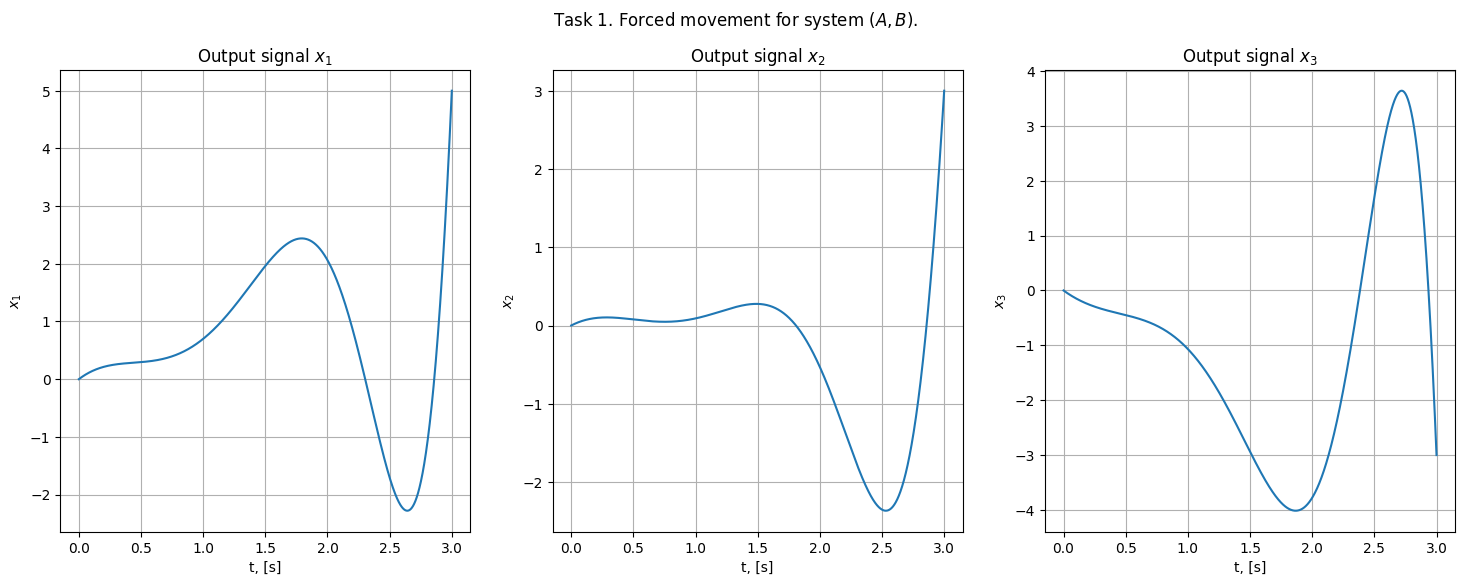

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Task 1. Forced movement for system $(A, B)$.")

for j in range(3):
    ax[j].plot(time_1, sys_out.states[j,:])
    ax[j].set_ylabel(f"$x_{j+1}$")
    ax[j].set_xlabel("t, [s]")
    ax[j].grid(True)
    ax[j].set_title(f"Output signal $x_{j+1}$")

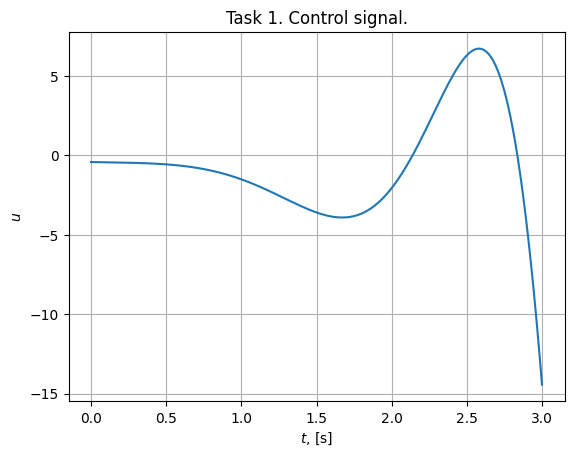

In [79]:
plt.plot(time_1,u_s)
plt.title("Task 1. Control signal.")
plt.xlabel(f"$t$, [s]")
plt.ylabel(f"$u$")
plt.grid()

## Task 2

In [38]:
A = np.array([
    [7, -7, 8],
    [6, -5, 6],
    [-6, 4, -7]
])

B = np.array([
    [2],
    [0],
    [0]
])

x_1_hat = np.array([
    [5],
    [3],
    [-3]
])

x_2_hat = np.array([
    [4],
    [3],
    [-2]
])

### subtask 1

In [39]:
U = np.concatenate([B, A.dot(B), A.dot(A.dot(B))],axis=1)
U

array([[  2,  14, -82],
       [  0,  12, -48],
       [  0, -12,  48]])

In [40]:
np.linalg.matrix_rank(U)

2

In [48]:
np.linalg.matrix_rank(np.concatenate([U, x_1_hat],axis=1))

2

In [49]:
np.linalg.matrix_rank(np.concatenate([U, x_2_hat],axis=1))

3

x_1_hat is in controllable subspace

### subtask 2

In [41]:
A_sym = sympy.Matrix(A)
B_sym = sympy.Matrix(B)
P, J = A_sym.jordan_form()
J

Matrix([
[-1,        0,        0],
[ 0, -2 - 3*I,        0],
[ 0,        0, -2 + 3*I]])

method 1 (rank creterion)

In [45]:
np.linalg.matrix_rank(np.concatenate([A-(-1)*np.identity(3),B],axis=1))

2

In [46]:
np.linalg.matrix_rank(np.concatenate([A-(-2-3j)*np.identity(3),B],axis=1))

3

In [47]:
np.linalg.matrix_rank(np.concatenate([A-(-2+3j)*np.identity(3),B],axis=1))

3

method 2 (Jordan representation)

In [50]:
J

Matrix([
[-1,        0,        0],
[ 0, -2 - 3*I,        0],
[ 0,        0, -2 + 3*I]])

In [51]:
P.inv() @ B

Matrix([
[   0],
[-2*I],
[ 2*I]])

-1 is non controllable

### subtask 3

we have chosen x_1 to be in controllable space

### subtask 4

In [62]:
G_cont_2 = grammian_cont(A_sym,B_sym,3)
G_cont_2.simplify()
G_cont_2

Matrix([
[-67*exp(-12)*cos(9)**2/13 - 63*exp(-12)*sin(9)**2/13 - 72*exp(-12)*sin(9)*cos(9)/13 + 67/13, -33*exp(-12)*cos(9)**2/13 - 45*exp(-12)*sin(9)**2/13 - 44*exp(-12)*sin(9)*cos(9)/13 + 33/13, -33/13 + 44*exp(-12)*sin(9)*cos(9)/13 + 45*exp(-12)*sin(9)**2/13 + 33*exp(-12)*cos(9)**2/13],
[-33*exp(-12)*cos(9)**2/13 - 45*exp(-12)*sin(9)**2/13 - 44*exp(-12)*sin(9)*cos(9)/13 + 33/13, -18*exp(-12)*cos(9)**2/13 - 34*exp(-12)*sin(9)**2/13 - 24*exp(-12)*sin(9)*cos(9)/13 + 18/13, -18/13 + 24*exp(-12)*sin(9)*cos(9)/13 + 34*exp(-12)*sin(9)**2/13 + 18*exp(-12)*cos(9)**2/13],
[-33/13 + 44*exp(-12)*sin(9)*cos(9)/13 + 45*exp(-12)*sin(9)**2/13 + 33*exp(-12)*cos(9)**2/13, -18/13 + 24*exp(-12)*sin(9)*cos(9)/13 + 34*exp(-12)*sin(9)**2/13 + 18*exp(-12)*cos(9)**2/13, -18*exp(-12)*cos(9)**2/13 - 34*exp(-12)*sin(9)**2/13 - 24*exp(-12)*sin(9)*cos(9)/13 + 18/13]])

In [63]:
G_cont_2.evalf()

Matrix([
[ 5.15382758646532,  2.53845278703287, -2.53845278703287],
[ 2.53845278703287,  1.38460985216837, -1.38460985216837],
[-2.53845278703287, -1.38460985216837,  1.38460985216837]])

In [64]:
G_cont_2.evalf().eigenvals()

{7.74425728549087: 1, 0.178790005311196: 1, 2.22358283615765e-64: 1}

In [66]:
G_cont_2.evalf().det()

-1.77635683940025e-15

### subtask 5

In [131]:
x_1_sym_2 = sympy.Matrix(x_1_hat)
x_1_sym_2

Matrix([
[ 5],
[ 3],
[-3]])

In [132]:
u_2 = B_sym.T @ sympy.exp(A_sym.T * (3 - t)) @ G_cont_2.evalf().pinv() @ x_1_sym_2
u_2

Matrix([[-10.0000602188239*exp(2*t - 6)*sin(3*t - 9) - 2.00003235501539*exp(2*t - 6)*cos(3*t - 9)]])

### subtask 6

In [133]:
u_f_2 = lambdify(t,u_2[0,0],'numpy')

In [134]:
system_2 = ctrl.ss(A,B,[0,0,0],0)
system_2

<LinearIOSystem:sys[8]:['u[0]']->['y[0]']>

In [135]:
time_2 = np.linspace(0,3,int(3/dt))
u_s_2 = u_f_2(time_2)
sys_out_2 = ctrl.forced_response(system_2,U=u_s_2,X0=0,T=time_2)

In [136]:
sys_out_2.states[:,-1]

array([ 4.99998991,  2.99999575, -2.99999575])

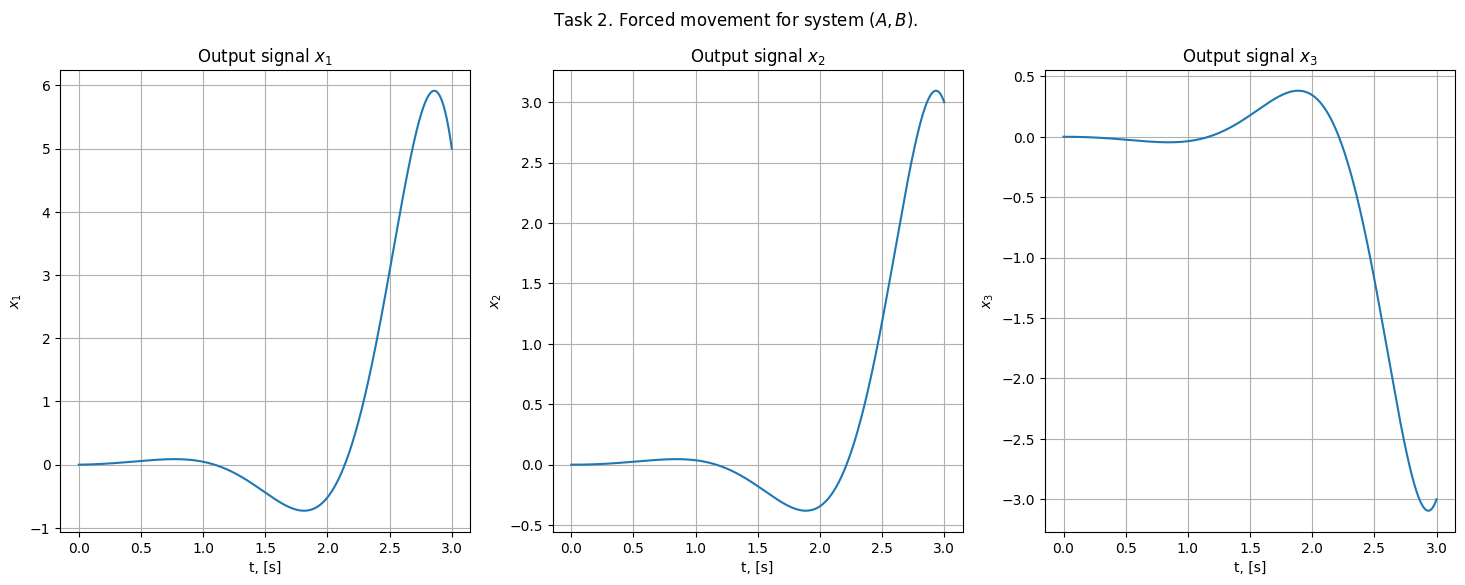

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Task 2. Forced movement for system $(A, B)$.")

for j in range(3):
    ax[j].plot(time_2, sys_out_2.states[j,:])
    ax[j].set_ylabel(f"$x_{j+1}$")
    ax[j].set_xlabel("t, [s]")
    ax[j].grid(True)
    ax[j].set_title(f"Output signal $x_{j+1}$")

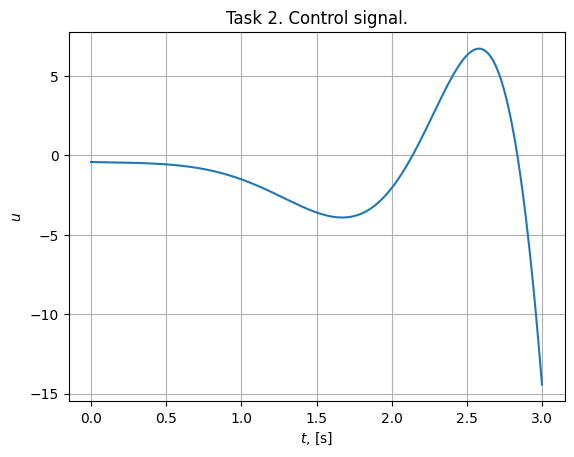

In [138]:
plt.plot(time_1,u_s)
plt.title("Task 2. Control signal.")
plt.xlabel(f"$t$, [s]")
plt.ylabel(f"$u$")
plt.grid()

## Task 3

In [10]:
A = np.array([
    [-10, 3, -8],
    [-5, 0, -6],
    [6, -4, 3]
])

C = np.array([[2, 1, 5]])

y = -3 * sympy.exp(-4*t)*sympy.cos(t) + 3*sympy.exp(-4*t)*sympy.sin(t)

In [69]:
y

3*exp(-4*t)*sin(t) - 3*exp(-4*t)*cos(t)

### subtask 1

In [12]:
V = np.concatenate([C,C@A,C@A@A])
V

array([[  2,   1,   5],
       [  5, -14,  -7],
       [-22,  43,  23]])

In [13]:
np.linalg.matrix_rank(V)

3

System is fully observable

### subtask 2

In [14]:
A_sym = sympy.Matrix(A)
C_sym = sympy.Matrix(C)
P, J = A_sym.jordan_form()
J

Matrix([
[1,      0,      0],
[0, -4 - I,      0],
[0,      0, -4 + I]])

In [15]:
np.linalg.matrix_rank(np.concatenate([A-(1)*np.identity(3),C]))

3

In [16]:
np.linalg.matrix_rank(np.concatenate([A-(-4-1j)*np.identity(3),C]))

3

In [17]:
np.linalg.matrix_rank(np.concatenate([A-(-4+1j)*np.identity(3),C]))

3

method 2 (Jordan representation)

In [ ]:
J

Matrix([
[-1,        0,        0],
[ 0, -2 - 3*I,        0],
[ 0,        0, -2 + 3*I]])

In [18]:
C @ P

Matrix([[2, 3/2 - 3*I/2, 3/2 + 3*I/2]])

### subtask 3

In [25]:
G_obs = grammian_obs_sci(A,C,3)

In [28]:
G_obs = G_obs[0]
G_obs

array([[ 806.09075913, -803.52504564,  808.02334244],
       [-803.52504564,  802.34903802, -804.23336424],
       [ 808.02334244, -804.23336424,  811.04783751]])

In [29]:
np.linalg.eigvals(G_obs)

array([2.41702915e+03, 2.48738683e-03, 2.45599899e+00])

### subtask 4

In [31]:
G_obs_sym = sympy.Matrix(G_obs)
G_obs_sym

Matrix([
[ 806.090759134369, -803.525045637137,  808.023342439506],
[-803.525045637137,  802.349038022218, -804.233364236433],
[ 808.023342439506, -804.233364236433,  811.047837509307]])

In [57]:
func = lambda x : scipy.linalg.expm(A.T*x) @ C.T * float(sympy.N(y.subs({t: x})))
x_0 = np.linalg.inv(G_obs) @ scipy.integrate.quad_vec(func,0,3)[0]

In [58]:
x_0

array([[ 3.],
       [ 1.],
       [-2.]])

### subtask 5

system is fully observable, so it is impossible to have other initial conditions, corresponding to this trajectory

### subtask 6

In [59]:
system_3 = ctrl.ss(A,[[0],[0],[0]],C,0)
system_3

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

In [61]:
time_3 = np.linspace(0,3,int(3/dt))
u_s_3 = np.zeros_like(time_3)
sys_out_3 = ctrl.forced_response(system_3,U=u_s_3,X0=x_0,T=time_3)

In [62]:
sys_out_3.states[:,0]

array([ 3.,  1., -2.])

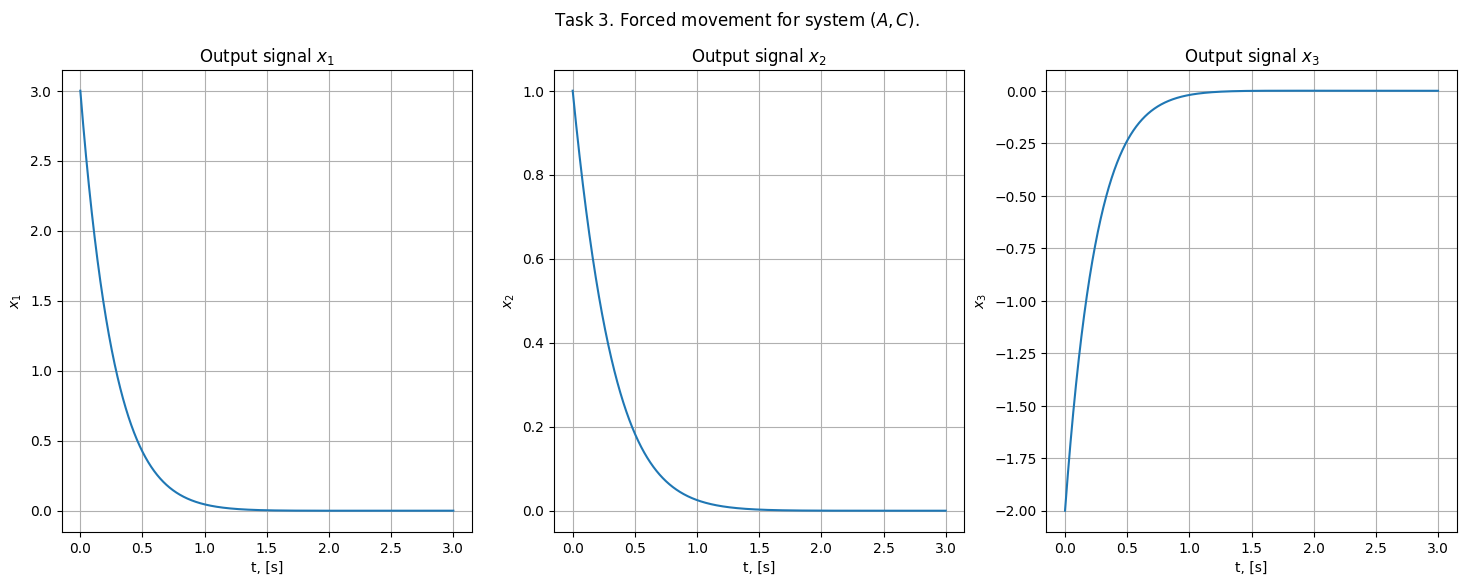

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Task 3. Forced movement for system $(A, C)$.")

for j in range(3):
    ax[j].plot(time_3, sys_out_3.states[j,:])
    ax[j].set_ylabel(f"$x_{j+1}$")
    ax[j].set_xlabel("t, [s]")
    ax[j].grid(True)
    ax[j].set_title(f"Output signal $x_{j+1}$")

In [65]:
y_func = lambdify(t,y,"numpy")

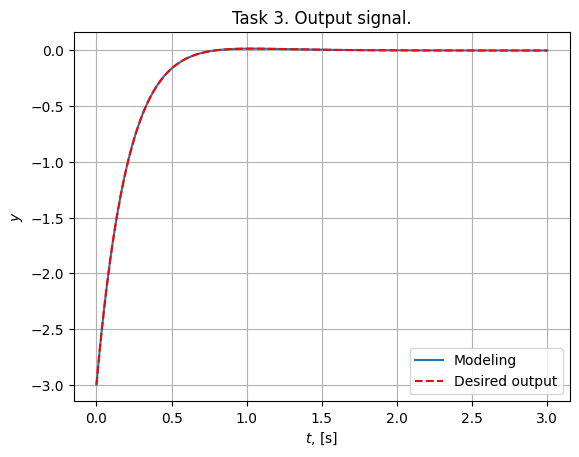

In [68]:
plt.plot(time_3,sys_out_3.outputs,label="Modeling")
plt.plot(time_3,y_func(time_3),"r--",label="Desired output")
plt.title("Task 3. Output signal.")
plt.xlabel(f"$t$, [s]")
plt.ylabel(f"$y$")
plt.grid()
plt.legend()

## Task 4

In [70]:
A = np.array([
    [-10, 3, -8],
    [-5, 0, -6],
    [6, -4, 3]
])

C = np.array([[0, 3, 3]])

y = -3 * sympy.exp(-4*t)*sympy.cos(t) + 3*sympy.exp(-4*t)*sympy.sin(t)

In [71]:
y

3*exp(-4*t)*sin(t) - 3*exp(-4*t)*cos(t)

### subtask 1

In [72]:
V = np.concatenate([C,C@A,C@A@A])
V

array([[  0,   3,   3],
       [  3, -12,  -9],
       [-24,  45,  21]])

In [92]:
sympy.Matrix(V).nullspace()

[Matrix([
 [-1],
 [-1],
 [ 1]])]

In [73]:
np.linalg.matrix_rank(V)

2

System is not fully observable

### subtask 2

In [74]:
A_sym = sympy.Matrix(A)
C_sym = sympy.Matrix(C)
P, J = A_sym.jordan_form()
J

Matrix([
[1,      0,      0],
[0, -4 - I,      0],
[0,      0, -4 + I]])

In [75]:
np.linalg.matrix_rank(np.concatenate([A-(1)*np.identity(3),C]))

2

In [76]:
np.linalg.matrix_rank(np.concatenate([A-(-4-1j)*np.identity(3),C]))

3

In [77]:
np.linalg.matrix_rank(np.concatenate([A-(-4+1j)*np.identity(3),C]))

3

method 2 (Jordan representation)

In [78]:
J

Matrix([
[1,      0,      0],
[0, -4 - I,      0],
[0,      0, -4 + I]])

In [79]:
C @ P

Matrix([[0, 3/2 - 3*I/2, 3/2 + 3*I/2]])

1 is not observable

### subtask 3

In [80]:
G_obs = grammian_obs_sci(A,C,3)

In [81]:
G_obs = G_obs[0]
G_obs

array([[0.03308824, 0.13235294, 0.16544118],
       [0.13235294, 1.09191176, 1.22426471],
       [0.16544118, 1.22426471, 1.38970588]])

In [82]:
np.linalg.eigvals(G_obs)

array([2.49230234e+00, 2.24035407e-02, 1.76439998e-17])

### subtask 4

In [83]:
G_obs_sym = sympy.Matrix(G_obs)
G_obs_sym

Matrix([
[0.0330882352934685, 0.132352941177257, 0.165441176470726],
[ 0.132352941177258,  1.09191176466406,  1.22426470584132],
[ 0.165441176470726,  1.22426470584132,  1.38970588231205]])

In [84]:
func = lambda x : scipy.linalg.expm(A.T*x) @ C.T * float(sympy.N(y.subs({t: x})))
x_0 = np.linalg.pinv(G_obs) @ scipy.integrate.quad_vec(func,0,3)[0]

In [85]:
x_0

array([[ 1.00000000e+00],
       [-1.00000000e+00],
       [ 1.77635684e-15]])

### subtask 5

system is fully observable, so it is impossible to have other initial conditions, corresponding to this trajectory

### subtask 6

add linear subspace based on vector [-1, -1, 1] from unobservable space

In [86]:
system_4 = ctrl.ss(A,[[0],[0],[0]],C,0)
system_4

<LinearIOSystem:sys[3]:['u[0]']->['y[0]']>

In [87]:
time_4 = np.linspace(0,3,int(3/dt))
u_s_4 = np.zeros_like(time_4)
sys_out_4 = ctrl.forced_response(system_4,U=u_s_4,X0=x_0,T=time_4)

In [88]:
sys_out_4.states[:,0]

array([ 1.00000000e+00, -1.00000000e+00,  1.77635684e-15])

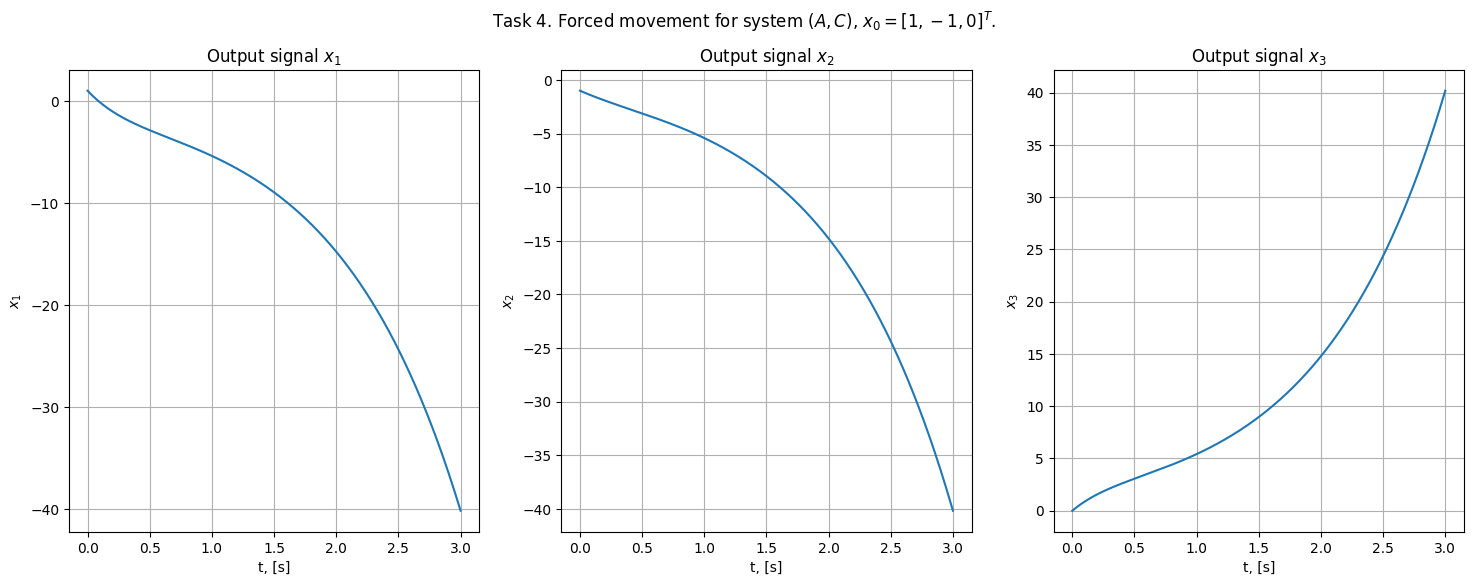

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Task 4. Forced movement for system $(A, C)$, $x_0=[1,-1,0]^T$.")

for j in range(3):
    ax[j].plot(time_4, sys_out_4.states[j,:])
    ax[j].set_ylabel(f"$x_{j+1}$")
    ax[j].set_xlabel("t, [s]")
    ax[j].grid(True)
    ax[j].set_title(f"Output signal $x_{j+1}$")

In [90]:
y_func = lambdify(t,y,"numpy")

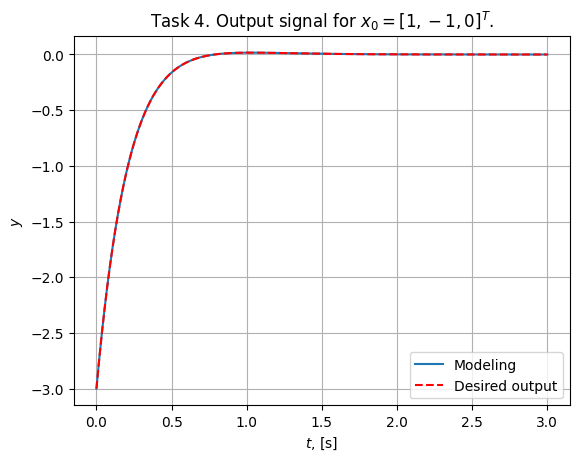

In [91]:
plt.plot(time_4,sys_out_4.outputs,label="Modeling")
plt.plot(time_4,y_func(time_4),"r--",label="Desired output")
plt.title("Task 4. Output signal for $x_0=[1,-1,0]^T$.")
plt.xlabel(f"$t$, [s]")
plt.ylabel(f"$y$")
plt.grid()
plt.legend()

In [100]:
sys_out_4 = ctrl.forced_response(system_4,U=u_s_4,X0=x_0+10*np.array([-1,-1,1]).reshape((-1,1)),T=time_4)

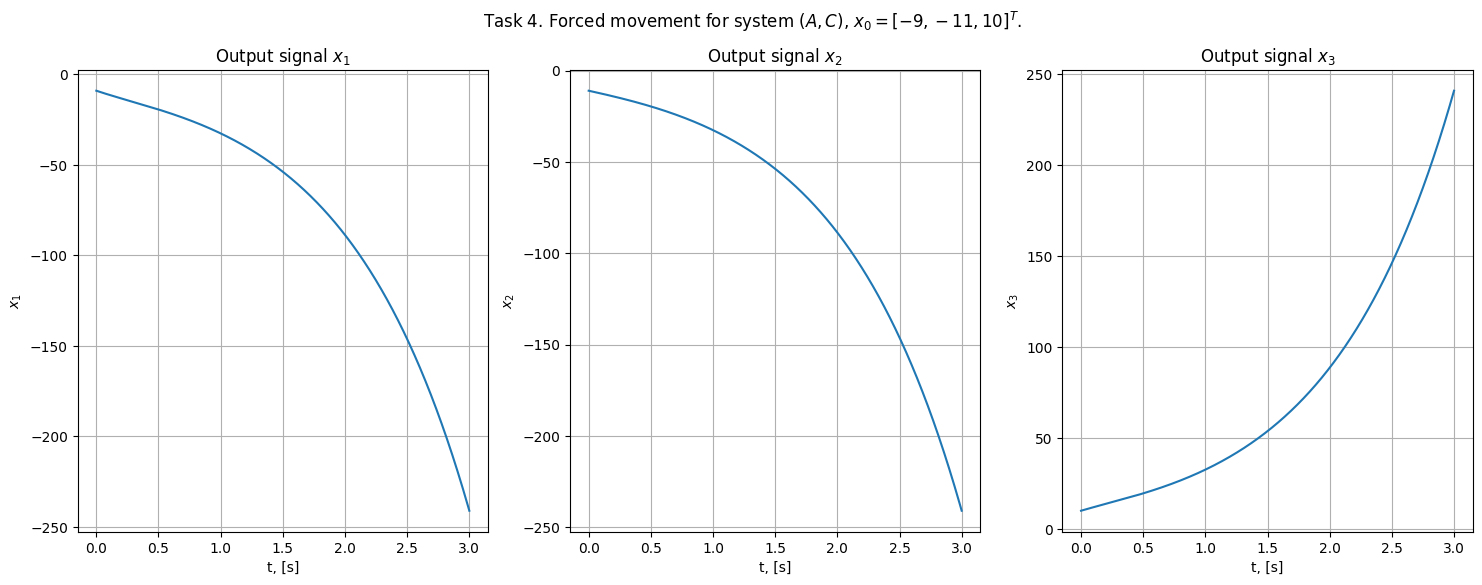

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Task 4. Forced movement for system $(A, C)$, $x_0=[-9,-11,10]^T$.")

for j in range(3):
    ax[j].plot(time_4, sys_out_4.states[j,:])
    ax[j].set_ylabel(f"$x_{j+1}$")
    ax[j].set_xlabel("t, [s]")
    ax[j].grid(True)
    ax[j].set_title(f"Output signal $x_{j+1}$")

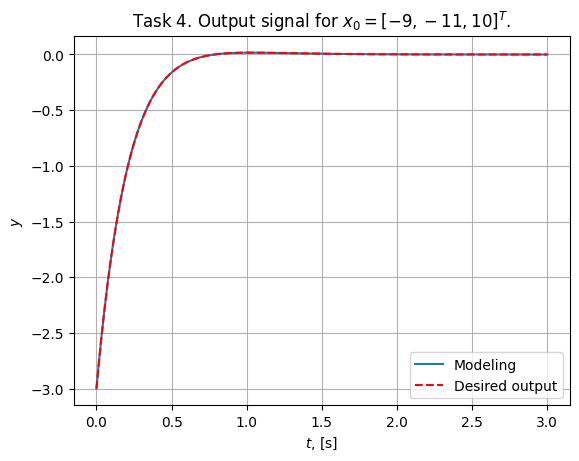

In [102]:
plt.plot(time_4,sys_out_4.outputs,label="Modeling")
plt.plot(time_4,y_func(time_4),"r--",label="Desired output")
plt.title("Task 4. Output signal for $x_0=[-9,-11,10]^T$.")
plt.xlabel(f"$t$, [s]")
plt.ylabel(f"$y$")
plt.grid()
plt.legend()

In [105]:
x_0-20*np.array([-1,-1,1]).reshape((-1,1))

array([[ 21.],
       [ 19.],
       [-20.]])

In [106]:
sys_out_4 = ctrl.forced_response(system_4,U=u_s_4,X0=x_0-20*np.array([-1,-1,1]).reshape((-1,1)),T=time_4)

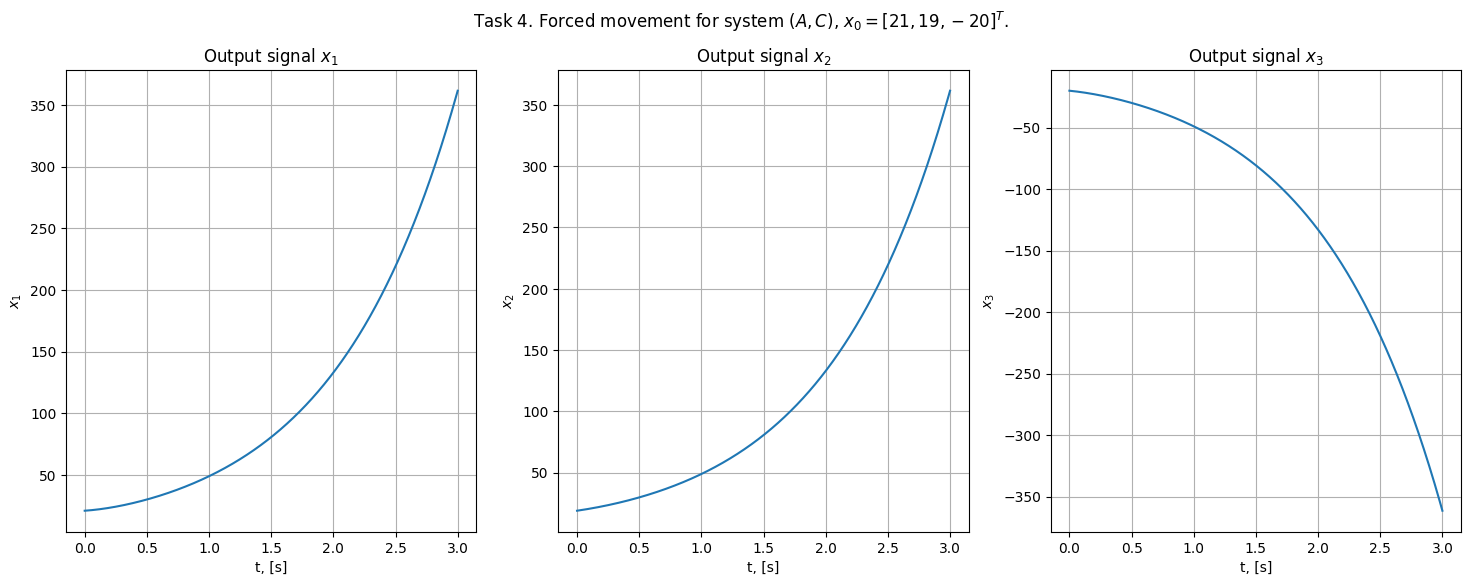

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Task 4. Forced movement for system $(A, C)$, $x_0=[21,19,-20]^T$.")

for j in range(3):
    ax[j].plot(time_4, sys_out_4.states[j,:])
    ax[j].set_ylabel(f"$x_{j+1}$")
    ax[j].set_xlabel("t, [s]")
    ax[j].grid(True)
    ax[j].set_title(f"Output signal $x_{j+1}$")

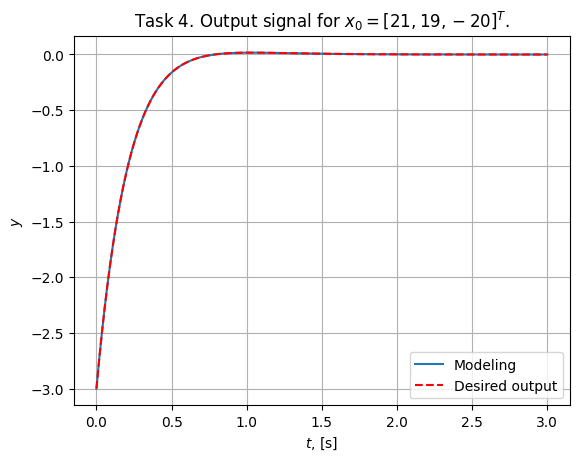

In [108]:
plt.plot(time_4,sys_out_4.outputs,label="Modeling")
plt.plot(time_4,y_func(time_4),"r--",label="Desired output")
plt.title("Task 4. Output signal for $x_0=[21,19,-20]^T$.")
plt.xlabel(f"$t$, [s]")
plt.ylabel(f"$y$")
plt.grid()
plt.legend()